In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, HTML
from Bio import SeqIO
import os
#from astropy import units as u
import sys
from readpaf import parse_paf

#from itables import init_notebook_mode
#init_notebook_mode(all_interactive=True)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [79]:
def perc(a, b):
    return 100.0 * a / b

def fasta2df(fn):
    seqs = SeqIO.parse(fn, "fasta")
    df = pd.DataFrame((str(s.id), str(s.seq)) for s in seqs)
    df.columns = ["ID", "Sequence"]
    return df

def is_correct(a):
    min_overlap = 0.1
    if a.GT_ref != a.target_name:
        return False
    if a.GT_strand != a.strand:
        return False
    intersect_from = max(a.GT_from, a.target_start)
    intersect_to = min(a.GT_to, a.target_end)
    union_from = min(a.GT_from, a.target_start)
    union_to = max(a.GT_to, a.target_end)
    overlaps = intersect_to - intersect_from >= min_overlap * (union_to - union_from)
    return overlaps
    
def read_paf(pref, reads):
    paf_file = pref.with_suffix('.paf')
    no_GT = False
    if not paf_file.exists():
        raise Exception(f"File does not exist or is empty: {paf_file}")
    with open(paf_file) as handle:
        df = parse_paf(handle, dataframe=True)
        try:
            df[ ['read_name', 'GT_ref', 'GT_from', 'GT_to', 'GT_strand'] ] = df['query_name'].str.split('!', expand=True)
            df['GT_from'] = df['GT_from'].astype(int)
            df['GT_to'] = df['GT_to'].astype(int)
            df['is_correct'] = df.apply(is_correct, axis=1)
        except ValueError as e:
            df['read_name'] = df['query_name']
            df['is_correct'] = True
            no_GT = True
    df = df.sort_values(['read_name', 'residue_matches'], ascending=[True, False], ignore_index=True)
    #display(df[['read_name', 'alignment_block_length']].head(50))
    #display(df[df.read_name == 'S1_18299'])

    incorrect_pref = 'bad'
    unique = 'uniq'
    multi = 'mult'
    paf = {}
    paf[unique] = 0
    paf[multi] = 0
    paf['unmapped'] = 0
    for suffix in ['', ' Q60']:
        paf[incorrect_pref + suffix] = 0
        paf[incorrect_pref + ' ' + unique + suffix] = 0
        paf[incorrect_pref + ' ' + multi + suffix] = 0
    prev_read_name = None

    for index, a in df.iterrows():
        assert(df.loc[index, 'read_name'] == a.read_name)
        next_read_name = df.loc[index + 1, 'read_name'] if index + 1 < len(df) else None
        is_unique = a.read_name != prev_read_name and a.read_name != next_read_name
        if is_unique:
            paf[unique] += 1
        if a.read_name == prev_read_name:
            continue
        if not is_unique:
            paf[multi] += 1
        if not a.is_correct:
            #print('wrong:', a)
            suffix = ' Q60' if a.mapping_quality == 60 else ''
            paf[incorrect_pref + suffix] += 1
            if next_read_name != a.read_name:
                paf[incorrect_pref + ' ' + unique + suffix] += 1
            else:
                paf[incorrect_pref + ' ' + multi + suffix] += 1
        prev_read_name = a.read_name

    paf['unmapped'] = reads - paf[unique] - paf[multi]

    for key in [unique, multi, 'unmapped', incorrect_pref]:
        paf[key] = '{} ({:>6.2f}%)'.format(paf[key], perc(paf[key], reads))
    
    if no_GT:
        for suff in ['', ' '+unique, ' '+multi]:
            for suffsuff in ['', ' Q60']:
                paf[incorrect_pref + suff + suffsuff] = 'N/A' 

    return pd.Series(paf, dtype='object')
    
def read_eval(pref, reads):
    eval_file = pref.with_suffix('.eval')
    if not eval_file.exists() or os.stat(eval_file).st_size == 0:
        raise Exception(f"File does not exist or is empty: {eval_file}")
    evaldf = pd.read_csv(eval_file, sep='\t', names=['Q', 'quality', 'aligned', 'misaligned', 'misaligned/aligned', 'aligned cum'])
    evals = {}
    evals['eval aligned'] = evaldf.iloc[-1]['aligned cum']
    evals['eval misaligned'] = evaldf.iloc[-1]['misaligned']
    #display(f'aligned: {evals["eval aligned"]}, misaligned: {evals["eval misaligned"]}')
    q60row = evaldf[evaldf['quality'] == 60]
    assert(len(q60row) == 1)
    #evals['eval unaligned'] = reads - evals['eval aligned']
    evals['eval correct'] = evals['eval aligned'] - evals['eval misaligned']
    evals['eval Q60 aligned'] = q60row['aligned'].values[0]
    evals['eval Q60 misaligned'] = q60row['misaligned'].values[0]
    #evals['eval noncorrect%'] = (100.0 * (evals['eval misaligned'] + evals['eval unaligned']) / evals['eval aligned']) #.round(2)
    return pd.Series(evals, dtype='object')

def read_times(pref):
    times = {}
    with open(str(pref) + '.index.time') as f_index_time:
        index_time, index_mem = map(float, f_index_time.readline().split())
        times['time index'] = index_time #* u.second
        #times['index_mem'] = index_mem / 2**20
        with open(str(pref) + '.time') as f_time:
            total_time, total_mem = map(float, f_time.readline().split())
            #times['time total'] = total_time #* u.second
            times['time map'] = total_time - times['time index']
            times['mem total'] = (total_mem / 2**20) #* u.GB
    return pd.Series(times, dtype='object').map('{:.2f}'.format)


Build a table to compare the mappers by accuracy, runtime (indexing and mapping) and memory.

In [81]:
tools = ['sweepmap', 'sweepmap-slow', 'mapquik', 'blend', 'minimap', 'winnowmap'] 
#tools = ['winnowmap'] 
experiments = [
    ('t2tChrY', 't2tChrY-readst2tChrY-a0.99-d10-l10000'),
    ('chm13', 'chm13-readschm13-a0.99-d0.1-l10000'),
    ('t2tChrY', 't2tChrY-readst2tChrY-a0.99-d1-l24000'),
    ('chm13', 'HG002_24kb'),
]
empty_cell = -1

def get_comparison_table(refname, experiment, tools):
    alldf = pd.DataFrame()
    alldf.name = experiment
    ref = fasta2df(Path('refs') / (refname+'.fa'))
    reads = fasta2df(Path('reads') / Path(experiment+'.fa'))
    rows = []  # list of Series to be converted to DataFrame
    for tool in tools:
        d = Path("out") / experiment / tool / tool
        row = pd.Series({
            'tool': tool,
            'reads': len(reads),
        })
        row = pd.concat([row, read_paf(d, row['reads'])])     # .paf
        try:
            row = pd.concat([row, read_times(d)])   # .time, .index.time
        except Exception as e:
            print(f"An error occurred while reading times {d}: {e}")
            row['time index'] = empty_cell
            row['time map'] = empty_cell
            row['mem total'] = empty_cell
        rows.append(row)
    alldf = pd.DataFrame(rows)
    alldf = alldf.set_index('tool')
    alldf.index.name = None
    return alldf

def to_latex(df):
    latex = ""
    df.index = df.index.map(lambda x: f'\\{x}')
    df.columns = df.columns.str.replace(' ', '\\\\')
    df.columns = df.columns.str.replace('%', '\%')
    df.columns = df.columns.map(lambda x: '\makecell{' + x + '}')
    #df = df.astype(str).map(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)
    latex += df.to_latex(escape=False, label=f'tab:{refname}', caption=data, float_format = lambda x: '{:0.2f}'.format(x) if pd.notna(x) else '-')
    #latex += df.to_latex(float_format = lambda x: '{:0.2f}'.format(x) if pd.notna(x) else '-')
    latex += '\n'
    return latex

css = """ <style> table { font-family: "Courier New", Courier, monospace; } </style> """
display(HTML(css))
for refname, data in experiments:
    df = get_comparison_table(refname, data, tools).round(2)
    df = df.style.set_caption(data)
    display(df)
    #print(to_latex(df))

,reads,uniq,mult,unmapped,bad,bad uniq,bad mult,bad Q60,bad uniq Q60,bad mult Q60,time index,time map,mem total
sweepmap,62502,62502 (100.00%),0 ( 0.00%),0 ( 0.00%),4323 ( 6.92%),4323,0,9,9,0,0.82,12.83,0.57
sweepmap-slow,62502,62502 (100.00%),0 ( 0.00%),0 ( 0.00%),2587 ( 4.14%),2587,0,2,2,0,0.52,4669.81,0.62
mapquik,62502,54648 ( 87.43%),0 ( 0.00%),7854 ( 12.57%),15021 ( 24.03%),15021,0,0,0,0,0.50,5.40,1.48
blend,62502,52858 ( 84.57%),9644 ( 15.43%),0 ( 0.00%),6362 ( 10.18%),4905,1457,9,8,1,0.97,372.53,0.59
minimap,62502,58379 ( 93.40%),4123 ( 6.60%),0 ( 0.00%),2792 ( 4.47%),2473,319,0,0,0,1.63,1196.67,0.66
winnowmap,62502,35381 ( 56.61%),27121 ( 43.39%),0 ( 0.00%),3302 ( 5.28%),3,3299,36,30,6,5.26,55484.97,16.38


,reads,uniq,mult,unmapped,bad,bad uniq,bad mult,bad Q60,bad uniq Q60,bad mult Q60,time index,time map,mem total
sweepmap,31185,31185 (100.00%),0 ( 0.00%),0 ( 0.00%),307 ( 0.98%),307,0,2,2,0,75.03,1.82,20.63
sweepmap-slow,31185,31185 (100.00%),0 ( 0.00%),0 ( 0.00%),210 ( 0.67%),210,0,1,1,0,68.48,2510.69,21.22
mapquik,31185,30738 ( 98.57%),0 ( 0.00%),447 ( 1.43%),653 ( 2.09%),653,0,0,0,0,31.00,3.49,4.10
blend,31185,30622 ( 98.19%),561 ( 1.80%),2 ( 0.01%),353 ( 1.13%),283,70,1,0,1,51.42,14.33,5.37
minimap,31185,31061 ( 99.60%),124 ( 0.40%),0 ( 0.00%),190 ( 0.61%),180,10,0,0,0,76.36,67.84,10.19
winnowmap,31185,29575 ( 94.84%),1609 ( 5.16%),1 ( 0.00%),198 ( 0.63%),0,198,2,2,0,120.75,1316.74,3.29


,reads,uniq,mult,unmapped,bad,bad uniq,bad mult,bad Q60,bad uniq Q60,bad mult Q60,time index,time map,mem total
sweepmap,2744,2744 (100.00%),0 ( 0.00%),0 ( 0.00%),65 ( 2.37%),65,0,0,0,0,0.81,1.02,0.57
sweepmap-slow,2744,2744 (100.00%),0 ( 0.00%),0 ( 0.00%),40 ( 1.46%),40,0,0,0,0,1.04,238.66,0.66
mapquik,2744,2647 ( 96.47%),0 ( 0.00%),97 ( 3.53%),635 ( 23.14%),635,0,0,0,0,0.51,0.60,1.48
blend,2744,2326 ( 84.77%),418 ( 15.23%),0 ( 0.00%),120 ( 4.37%),97,23,0,0,0,1.09,53.86,0.18
minimap,2744,2545 ( 92.75%),199 ( 7.25%),0 ( 0.00%),41 ( 1.49%),37,4,0,0,0,1.65,161.43,0.29
winnowmap,2744,2384 ( 86.88%),360 ( 13.12%),0 ( 0.00%),43 ( 1.57%),0,43,0,0,0,17.47,10533.62,1.32


,reads,uniq,mult,unmapped,bad,bad uniq,bad mult,bad Q60,bad uniq Q60,bad mult Q60,time index,time map,mem total
sweepmap,22167,22167 (100.00%),0 ( 0.00%),0 ( 0.00%),N/A,N/A,N/A,N/A,N/A,N/A,72.78,7.54,20.63
sweepmap-slow,22167,22167 (100.00%),0 ( 0.00%),0 ( 0.00%),N/A,N/A,N/A,N/A,N/A,N/A,66.53,4130.17,21.46
mapquik,22167,21981 ( 99.16%),0 ( 0.00%),186 ( 0.84%),N/A,N/A,N/A,N/A,N/A,N/A,32.21,6.97,4.10
blend,22167,21352 ( 96.32%),806 ( 3.64%),9 ( 0.04%),N/A,N/A,N/A,N/A,N/A,N/A,52.77,31.54,5.37
minimap,22167,21324 ( 96.20%),840 ( 3.79%),3 ( 0.01%),N/A,N/A,N/A,N/A,N/A,N/A,78.82,173.75,10.19
winnowmap,22167,20947 ( 94.50%),1217 ( 5.49%),3 ( 0.01%),N/A,N/A,N/A,N/A,N/A,N/A,119.74,5344.10,3.06


Visualize how SweepMap parameters influence its accuracy and mapping runtime.

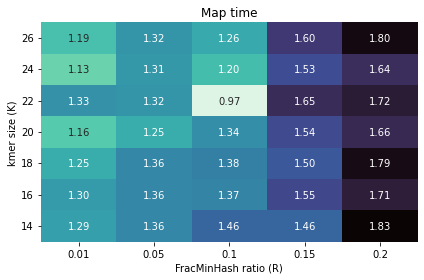

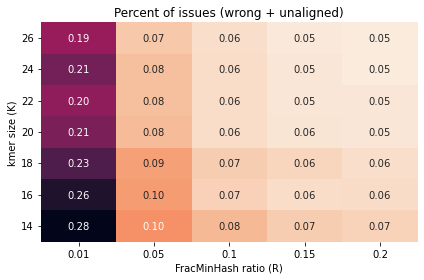

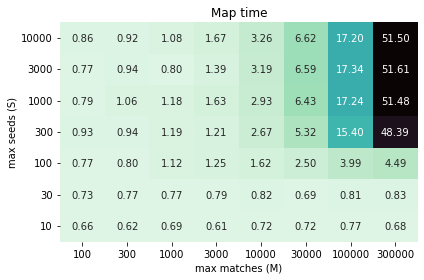

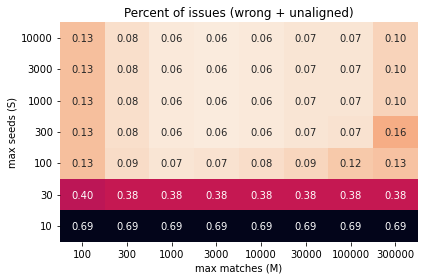

In [ ]:
Ks = [14, 16, 18, 20, 22, 24, 26]
Rs = ['0.01', '0.05', '0.1', '0.15', '0.2']

def read_matrix(Ys, Xs, ylabel, xlabel, experiment):
    TOOL = 'sweepmap'
    DATA = ('t2tChrY', 't2tChrY-a0.99-d1-l10000') # ('chm13', 'chm13-a0.99-d1-l10000')

    VARS = {'thinning': ('S', 'M'), 'sketching': ('K', 'R')}
    vary, varx = VARS[experiment]

    map_time_df = pd.DataFrame(index=Ys, columns=Xs)
    map_time_df.index.name = ylabel
    map_time_df.columns.name = xlabel
    issue_perc_df = map_time_df.copy() # pd.DataFrame(index=MAX_SEEDS, columns=MAX_MATCHES)

    for y in Ys:
        for x in Xs:
            refname, data = DATA
            reads = fasta2df(Path('reads') / Path('reads-'+data+'.fa'))
            pref = Path("out") / data / experiment / f'{TOOL}-{vary}{y}-{varx}{x}'
            eval_file = str(pref) + '.eval'
            unaligned,  aligned,  wrong,     issue_perc = get_eval(eval_file, len(reads))
            index_time, map_time, index_mem, total_mem  = get_times(pref)
            map_time_df.loc[y, x] = map_time
            issue_perc_df.loc[y, x] = issue_perc / 100.0

    return map_time_df, issue_perc_df

def plot_SM_heatmap(df, name, title, cm):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(df.astype(float), ax=ax, annot=True, fmt=".2f", cmap=cm) #, cbar=False)
    ax.set_title(title)
    ax.set_ylabel(df.index.name)
    ax.set_xlabel(df.columns.name)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    fig.savefig(f'imgs/{name}.png', dpi=300)
    plt.close(fig)

KR_map_time_df, KR_issue_perc_df = read_matrix(Ks, Rs, 'kmer size (K)', 'FracMinHash ratio (R)', 'sketching')
plot_SM_heatmap(KR_map_time_df, name='heatmapKR_maptime', title='Map time', cm='mako_r')
plot_SM_heatmap(KR_issue_perc_df, name='heatmapKR_percissues', title='Percent of issues (wrong + unaligned)', cm='rocket_r')

MAX_SEEDS = [10, 30, 100, 300, 1000, 3000, 10000]
MAX_MATCHES = [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]
SM_map_time_df, SM_issue_perc_df = read_matrix(MAX_SEEDS, MAX_MATCHES, 'max seeds (S)', 'max matches (M)', 'thinning')
plot_SM_heatmap(SM_map_time_df, name='heatmapSM_maptime', title='Map time', cm='mako_r')
plot_SM_heatmap(SM_issue_perc_df, name='heatmapSM_percissues', title='Percent of issues (wrong + unaligned)', cm='rocket_r')